In [1]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import shap
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from catboost import CatBoostClassifier
from statsmodels.tsa.stattools import ccf
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import xgboost

# Data Load

In [2]:
# 파일 호출
data_path: str = "../../data"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train 
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

In [3]:
# HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 할딩
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")


100%|██████████| 107/107 [00:03<00:00, 28.11it/s]


In [4]:
def make_df(df):
    # 모델에 사용할 컬럼, 컬럼의 rename rule을 미리 할당함
    cols_dict: Dict[str, str] = {
        "ID": "ID",
        "target": "target",
        "_type": "_type",
        # coinbase
        "hourly_market-data_coinbase-premium-index_coinbase_premium_gap": "coinbase_premium_gap",
        "hourly_market-data_coinbase-premium-index_coinbase_premium_index": "coinbase_premium_index",
        # funding_rate
        "hourly_market-data_funding-rates_all_exchange_funding_rates": "funding_rates",
        "hourly_market-data_funding-rates_bitmex_funding_rates": "funding_rates",
        
        "hourly_market-data_funding-rates_bitmex_funding_rates": "funding_rates_bitmex",
        # liquidations
        "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations": "long_liquidations",
        "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations_usd": "long_liquidations_usd",
        "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations": "short_liquidations",
        "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations_usd": "short_liquidations_usd",
        
        "hourly_market-data_liquidations_bybit_all_symbol_long_liquidations": "long_liquidations_bybit",
        "hourly_market-data_liquidations_bybit_all_symbol_short_liquidations": "short_liquidations_bybit",
        "hourly_market-data_liquidations_bitfinex_all_symbol_long_liquidations": "long_liquidations_bitfinex",
        "hourly_market-data_liquidations_bitfinex_all_symbol_short_liquidations": "short_liquidations_bitfinex",
        "hourly_market-data_liquidations_binance_all_symbol_long_liquidations": "long_liquidations_binance",
        "hourly_market-data_liquidations_binance_all_symbol_short_liquidations": "short_liquidations_binance",
        
        # open-interest
        "hourly_market-data_open-interest_all_exchange_all_symbol_open_interest": "open_interest",
        
        # taker_buy_sell
        "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio": "buy_ratio",
        "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_sell_ratio": "buy_sell_ratio",
        "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_volume": "buy_volume",
        "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_ratio": "sell_ratio",
        "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume": "sell_volume",
        
        'hourly_market-data_taker-buy-sell-stats_huobi_global_taker_buy_sell_ratio' : "buy_sell_ratio_huobi",
        "hourly_market-data_taker-buy-sell-stats_deribit_taker_buy_volume": "buy_volume_deribit",
        "hourly_market-data_taker-buy-sell-stats_deribit_taker_sell_volume": "sell_volume_deribit",
        "hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume": "buy_volume_bybit",
        "hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_volume": "sell_volume_bybit",
        "hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume": "buy_volume_okx",
        "hourly_market-data_taker-buy-sell-stats_okx_taker_sell_volume": "sell_volume_okx",
        
        # address
        "hourly_network-data_addresses-count_addresses_count_active": "active_count",
        "hourly_network-data_addresses-count_addresses_count_receiver": "receiver_count",
        "hourly_network-data_addresses-count_addresses_count_sender": "sender_count",
        
        # transactions_count
        'hourly_network-data_transactions-count_transactions_count_total' : "transactions_count_total",
        'hourly_network-data_transactions-count_transactions_count_mean' : "transactions_count_mean",
        
        # fees_block
        'hourly_network-data_fees_fees_block_mean' : "block_mean",
        'hourly_network-data_fees_fees_block_mean_usd' : "block_mean_usd",
        
        # fees
        'hourly_network-data_fees_fees_total' : 'fees_total',
        'hourly_network-data_fees_fees_total_usd' : 'fees_total_usd',
        'hourly_network-data_fees_fees_reward_percent' : 'fees_reward_percent',
        
        # difficulty
        'hourly_network-data_difficulty_difficulty' : 'difficulty',
        
        # utxo
        'hourly_network-data_utxo-count_utxo_count' : 'utxo_count',
        
        # supply
        'hourly_network-data_supply_supply_total' : 'supply_total',
        'hourly_network-data_supply_supply_new' : 'supply_new',
        
        # hashrate
        'hourly_network-data_hashrate_hashrate' : 'hashrate',
        
        # fees_transaction
        'hourly_network-data_fees-transaction_fees_transaction_mean' : 'fees_transaction_mean',
        'hourly_network-data_fees-transaction_fees_transaction_mean_usd' : 'fees_transaction_mean_usd',
        'hourly_network-data_fees-transaction_fees_transaction_median' : 'fees_transaction_median',
        'hourly_network-data_fees-transaction_fees_transaction_median_usd' : 'fees_transaction_median_usd',
        
        # blockreward
        'hourly_network-data_blockreward_blockreward' : 'blockreward',
        'hourly_network-data_blockreward_blockreward_usd' : 'blockreward_usd',
        'hourly_network-data_block-interval_block_interval' : 'block_interval',
        
        # transffered_tokens
        'hourly_network-data_tokens-transferred_tokens_transferred_total' : 'tokens_transferred_total',
        'hourly_network-data_tokens-transferred_tokens_transferred_mean' : 'tokens_transferred_mean',
        'hourly_network-data_tokens-transferred_tokens_transferred_median' : 'tokens_transferred_median',
        
        # block_bytes
        'hourly_network-data_block-bytes_block_bytes' : 'block_bytes',
        
        # velocity
        'hourly_network-data_velocity_velocity_supply_total' : 'velocity_supply_total'
        
    }
    df2 = df[cols_dict.keys()].rename(cols_dict, axis=1)
    return df2, cols_dict
    

In [5]:
def feature_engineering(df, cols_dict):
    # eda 에서 파악한 차이와 차이의 음수, 양수 여부를 새로운 피쳐로 생성
    epsilon=1e-6
    df2 = df.assign(
        # liquidation
        liquidation_diff=df["long_liquidations"] - df["short_liquidations"],
        liquidation_diff_bybit=df["long_liquidations_bybit"] - df["short_liquidations_bybit"],
        liquidation_index=(df["long_liquidations"] - df["short_liquidations"])/(df["long_liquidations"] + df["short_liquidations"]+ epsilon),
        liquidation_index_bitfinex=(df["long_liquidations_bitfinex"] - df["short_liquidations_bitfinex"])/(df["long_liquidations_bitfinex"] + df["short_liquidations_bitfinex"]+ epsilon),
        liquidation_index_binance=(df["long_liquidations_binance"] - df["short_liquidations_binance"])/(df["long_liquidations_binance"] + df["short_liquidations_binance"]+ epsilon),
        
        # taker buy sell
        volume_diff=df["buy_volume"] - df["sell_volume"],
        volume_diff_deribit=df["buy_volume_deribit"] - df["sell_volume_deribit"],
        volume_diff_bybit=df["buy_volume_bybit"] - df["sell_volume_bybit"],
        volume_diff_okx=df["buy_volume_okx"] - df["sell_volume_okx"],
        volume_index=(df["buy_volume"] - df["sell_volume"])/(df["buy_volume"] + df["sell_volume"]+ epsilon),
        
        # address
        address_diff = df["sender_count"] - df["receiver_count"],
        
        # interaction term
        buy_sell_volume_ratio=df["buy_volume"] / (df["sell_volume"] + epsilon),
        long_liquidation_interest_ratio = df["long_liquidations"]/df['open_interest'],
        short_liquidation_interest_ratio = df["short_liquidations"]/df['open_interest'],
        long_liquidation_volume_ratio = df["long_liquidations"]/(df['buy_volume']+df['sell_volume']+ epsilon),
        short_liquidation_volume_ratio = df["short_liquidations"]/(df['buy_volume']+df['sell_volume']+ epsilon),
        volume_interest_ratio = (df['buy_volume']+df['sell_volume'])/(df['open_interest']+ epsilon),

        market_pressure = (df['buy_ratio']*df['open_interest']) / (df['sell_ratio']*df['funding_rates']+epsilon),
        network_active = (df['active_count']*df['transactions_count_total'])/(df['block_interval']*df['block_bytes']+epsilon),
        Hodler = (df['utxo_count']*df['difficulty'])/(df['velocity_supply_total']*df['supply_new']+epsilon),
        profitability = (df['blockreward']*df['hashrate'])/(df['difficulty']*df['fees_total']+epsilon),
        investment = df['coinbase_premium_index']*df['tokens_transferred_mean']/(df['tokens_transferred_median']+epsilon),
        leverage = (df['long_liquidations'] + df['short_liquidations'])*df['open_interest']/(df['active_count']*df['tokens_transferred_total']+epsilon),
        fee_index = (df['fees_transaction_mean'] * df['transactions_count_total'])/(df['active_count']*df['supply_new']+epsilon),
        market_health = (df['hashrate']*df['active_count'])/(df['long_liquidations']+df['short_liquidations']+epsilon),
        exchange_center = (df['tokens_transferred_total'] - df['tokens_transferred_mean']*df['transactions_count_total'])/(df['utxo_count']+epsilon),
        
    )
    # category, continuous 열을 따로 할당해둠
    category_cols: List[str] = []
    conti_cols: List[str] = [_ for _ in cols_dict.values() if _ not in ["ID", "target", "_type"]] + [
        "liquidation_diff",
        "liquidation_diff_bybit",
        "liquidation_index",
        "liquidation_index_bitfinex",
        "liquidation_index_binance",
        
        "volume_diff",
        "volume_diff_deribit",
        "volume_diff_bybit",
        "volume_diff_okx",
        "volume_index",
        
        "address_diff",
        
        "buy_sell_volume_ratio",
        "long_liquidation_interest_ratio",
        "short_liquidation_interest_ratio",
        "long_liquidation_volume_ratio",
        "short_liquidation_volume_ratio",
        "volume_interest_ratio",
        
        "market_pressure",
        "network_active",
        "Hodler",
        "profitability",
        "investment",
        "leverage",
        "fee_index",
        "market_health",
        "exchange_center",
    ]
    return df2, category_cols, conti_cols

In [6]:
df2, cols_dict = make_df(df)

# 결측치 처리
파생 변수를 생성하기 전에 결측치를 처리해보자.

In [7]:
train_df = df2[df2._type == 'train'].drop(columns = ['_type', 'target', 'ID'])
test_df= df2[df2._type == 'test'].drop(columns = ['_type', 'target', 'ID'])

In [8]:
temp = train_df.copy()

iimp = IterativeImputer(
estimator = xgboost.XGBRegressor(),
random_state = 42,
verbose = 2,
max_iter=15
)

final = iimp.fit_transform(train_df)

[IterativeImputer] Completing matrix with shape (8760, 54)
[IterativeImputer] Ending imputation round 1/15, elapsed time 21.87
[IterativeImputer] Change: 15882020652404.398, scaled tolerance: 72006146478.5671 
[IterativeImputer] Ending imputation round 2/15, elapsed time 47.75
[IterativeImputer] Change: 520794222662.88983, scaled tolerance: 72006146478.5671 
[IterativeImputer] Ending imputation round 3/15, elapsed time 69.37
[IterativeImputer] Change: 235141245206.2908, scaled tolerance: 72006146478.5671 
[IterativeImputer] Ending imputation round 4/15, elapsed time 91.35
[IterativeImputer] Change: 358940148733.0492, scaled tolerance: 72006146478.5671 
[IterativeImputer] Ending imputation round 5/15, elapsed time 115.58
[IterativeImputer] Change: 356402674682.4908, scaled tolerance: 72006146478.5671 
[IterativeImputer] Ending imputation round 6/15, elapsed time 141.62
[IterativeImputer] Change: 576049998479.4775, scaled tolerance: 72006146478.5671 
[IterativeImputer] Ending imputation 

/opt/conda/lib/python3.10/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [9]:
final2 = iimp.transform(test_df)

train_df = pd.DataFrame(final, columns = train_df.columns)
test_df = pd.DataFrame(final2, columns = test_df.columns)
df3 = pd.concat([train_df, test_df], axis = 0).reset_index(drop=True)
df3[['ID', 'target','_type']] = df[['ID', 'target','_type']] 

[IterativeImputer] Completing matrix with shape (2792, 54)
[IterativeImputer] Ending imputation round 1/15, elapsed time 0.03
[IterativeImputer] Ending imputation round 2/15, elapsed time 0.06
[IterativeImputer] Ending imputation round 3/15, elapsed time 0.08
[IterativeImputer] Ending imputation round 4/15, elapsed time 0.12
[IterativeImputer] Ending imputation round 5/15, elapsed time 0.14
[IterativeImputer] Ending imputation round 6/15, elapsed time 0.17
[IterativeImputer] Ending imputation round 7/15, elapsed time 0.19
[IterativeImputer] Ending imputation round 8/15, elapsed time 0.22
[IterativeImputer] Ending imputation round 9/15, elapsed time 0.24
[IterativeImputer] Ending imputation round 10/15, elapsed time 0.27
[IterativeImputer] Ending imputation round 11/15, elapsed time 0.29
[IterativeImputer] Ending imputation round 12/15, elapsed time 0.32
[IterativeImputer] Ending imputation round 13/15, elapsed time 0.34
[IterativeImputer] Ending imputation round 14/15, elapsed time 0.3

# 변수 선택 (correlation)

In [10]:
# 파생 변수 생성에만 필요했던 변수들은 제거
drop_cols1 = ['long_liquidations_bybit', 'short_liquidations_bybit', 
             'long_liquidations_bitfinex', 'short_liquidations_bitfinex', 
             'long_liquidations_binance', 'short_liquidations_binance',
             'buy_volume_deribit', 'sell_volume_deribit',
             'buy_volume_bybit', 'sell_volume_bybit',
             'buy_volume_okx', 'sell_volume_okx',
             ]

### 기본 데이터셋

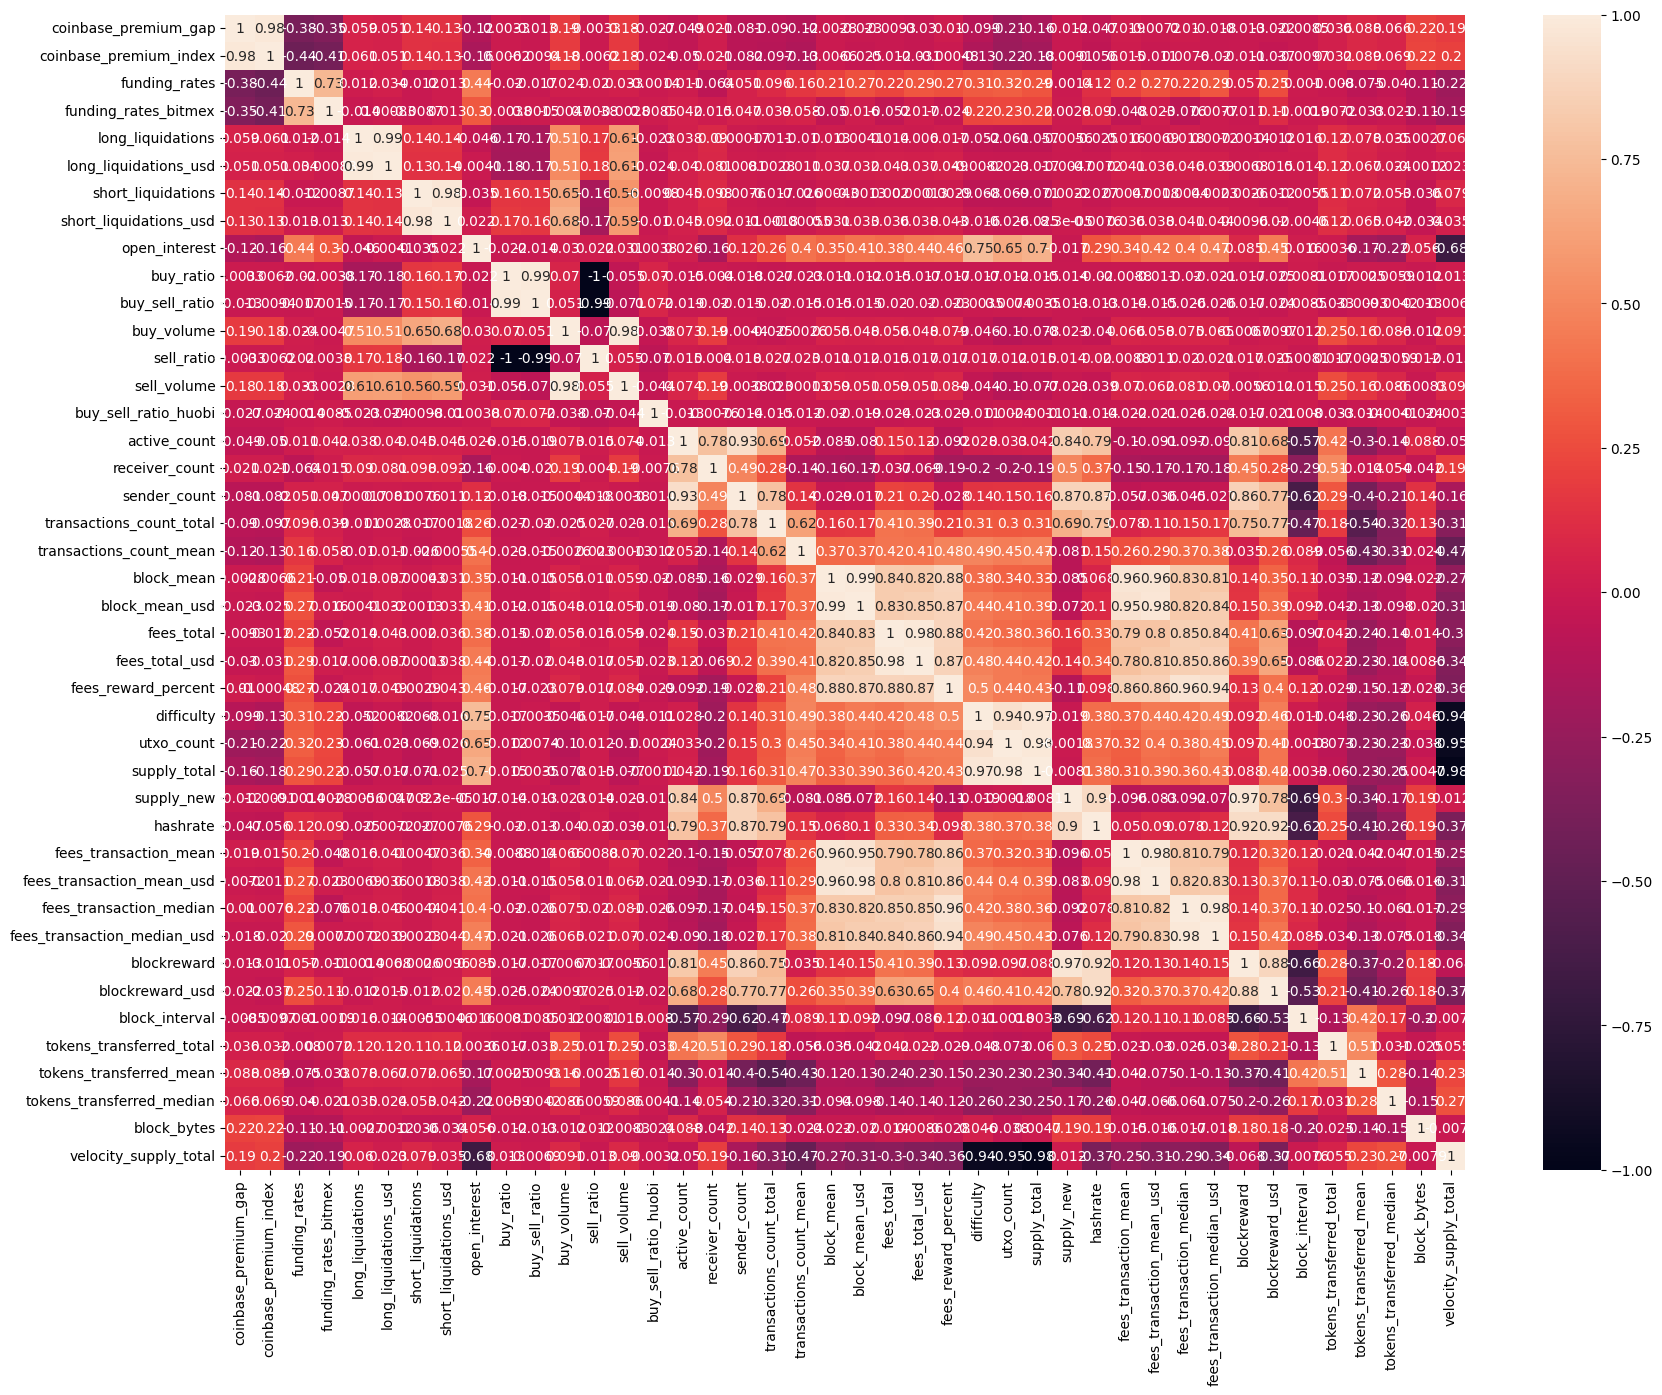

In [11]:
x = df3[df3.ID < '2024-01-01'].drop(columns = ['target', 'ID', '_type']+drop_cols1)
corr_matrix = x.corr('pearson')

plt.figure(figsize = (20,15))
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [12]:
# 제거할 변수 (corr 0.9 이상)
drop_cols2 = [
    'coinbase_premium_gap', 
    'long_liquidations_usd', 'short_liquidations_usd', 
    'buy_sell_ratio', 'sell_ratio', 'sell_volume',
    'block_mean', 'block_mean_usd', 'blockreward',
    'fees_total', 'fees_transaction_mean', 'fees_transaction_median', 
    'supply_total', 'utxo_count', 'supply_new', 'velocity_supply_total', 'fees_reward_percent', 'hashrate', 'sender_count'
]

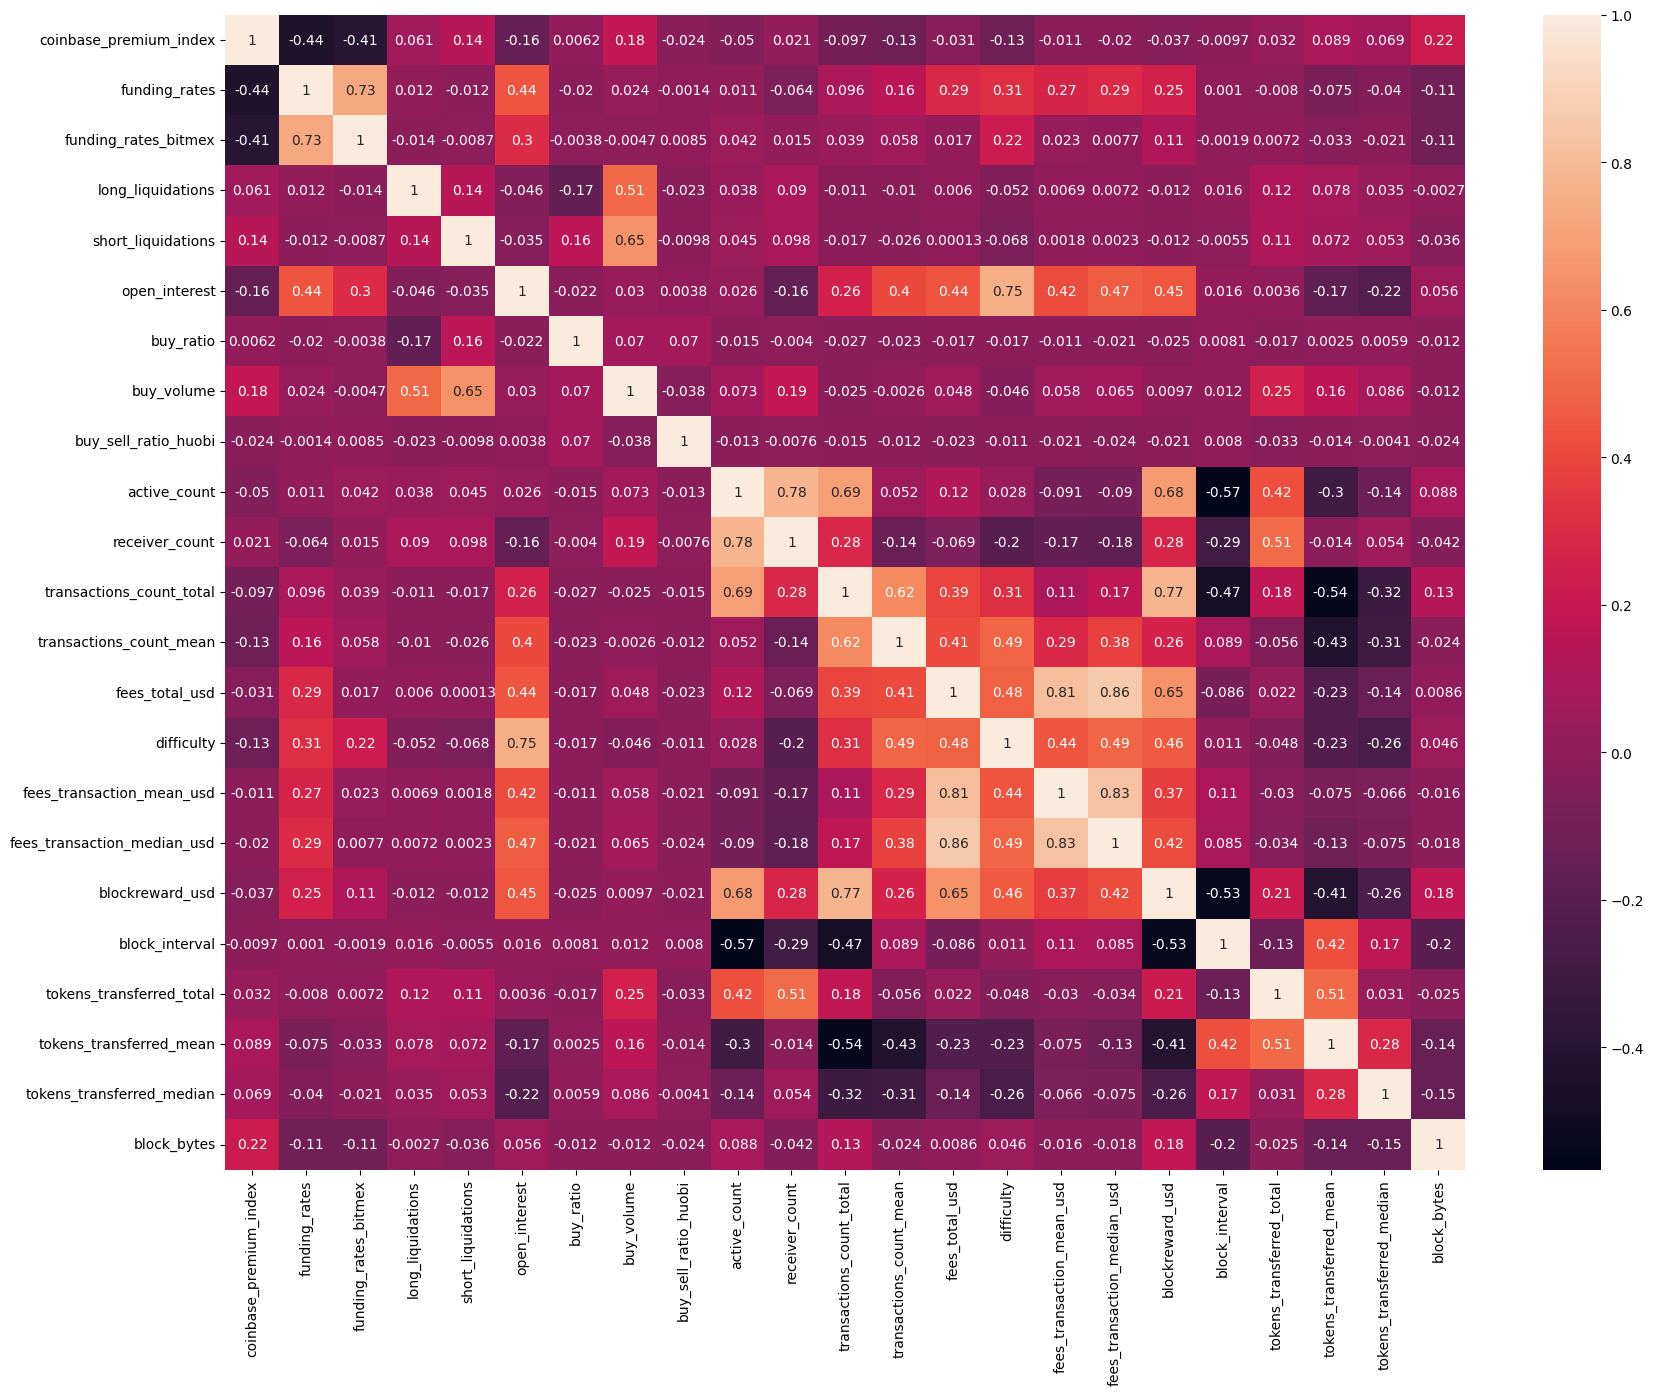

In [13]:
x = df3[df3.ID < '2024-01-01'].drop(columns = ['target', 'ID', '_type']+ drop_cols1 + drop_cols2)
corr_matrix = x.corr('pearson')

plt.figure(figsize = (20,15))
sns.heatmap(corr_matrix, annot=True)
plt.show()

### 파생 변수 생성 후

In [14]:
# 파생변수 생성
df3, category_cols, conti_cols = feature_engineering(df3, cols_dict)

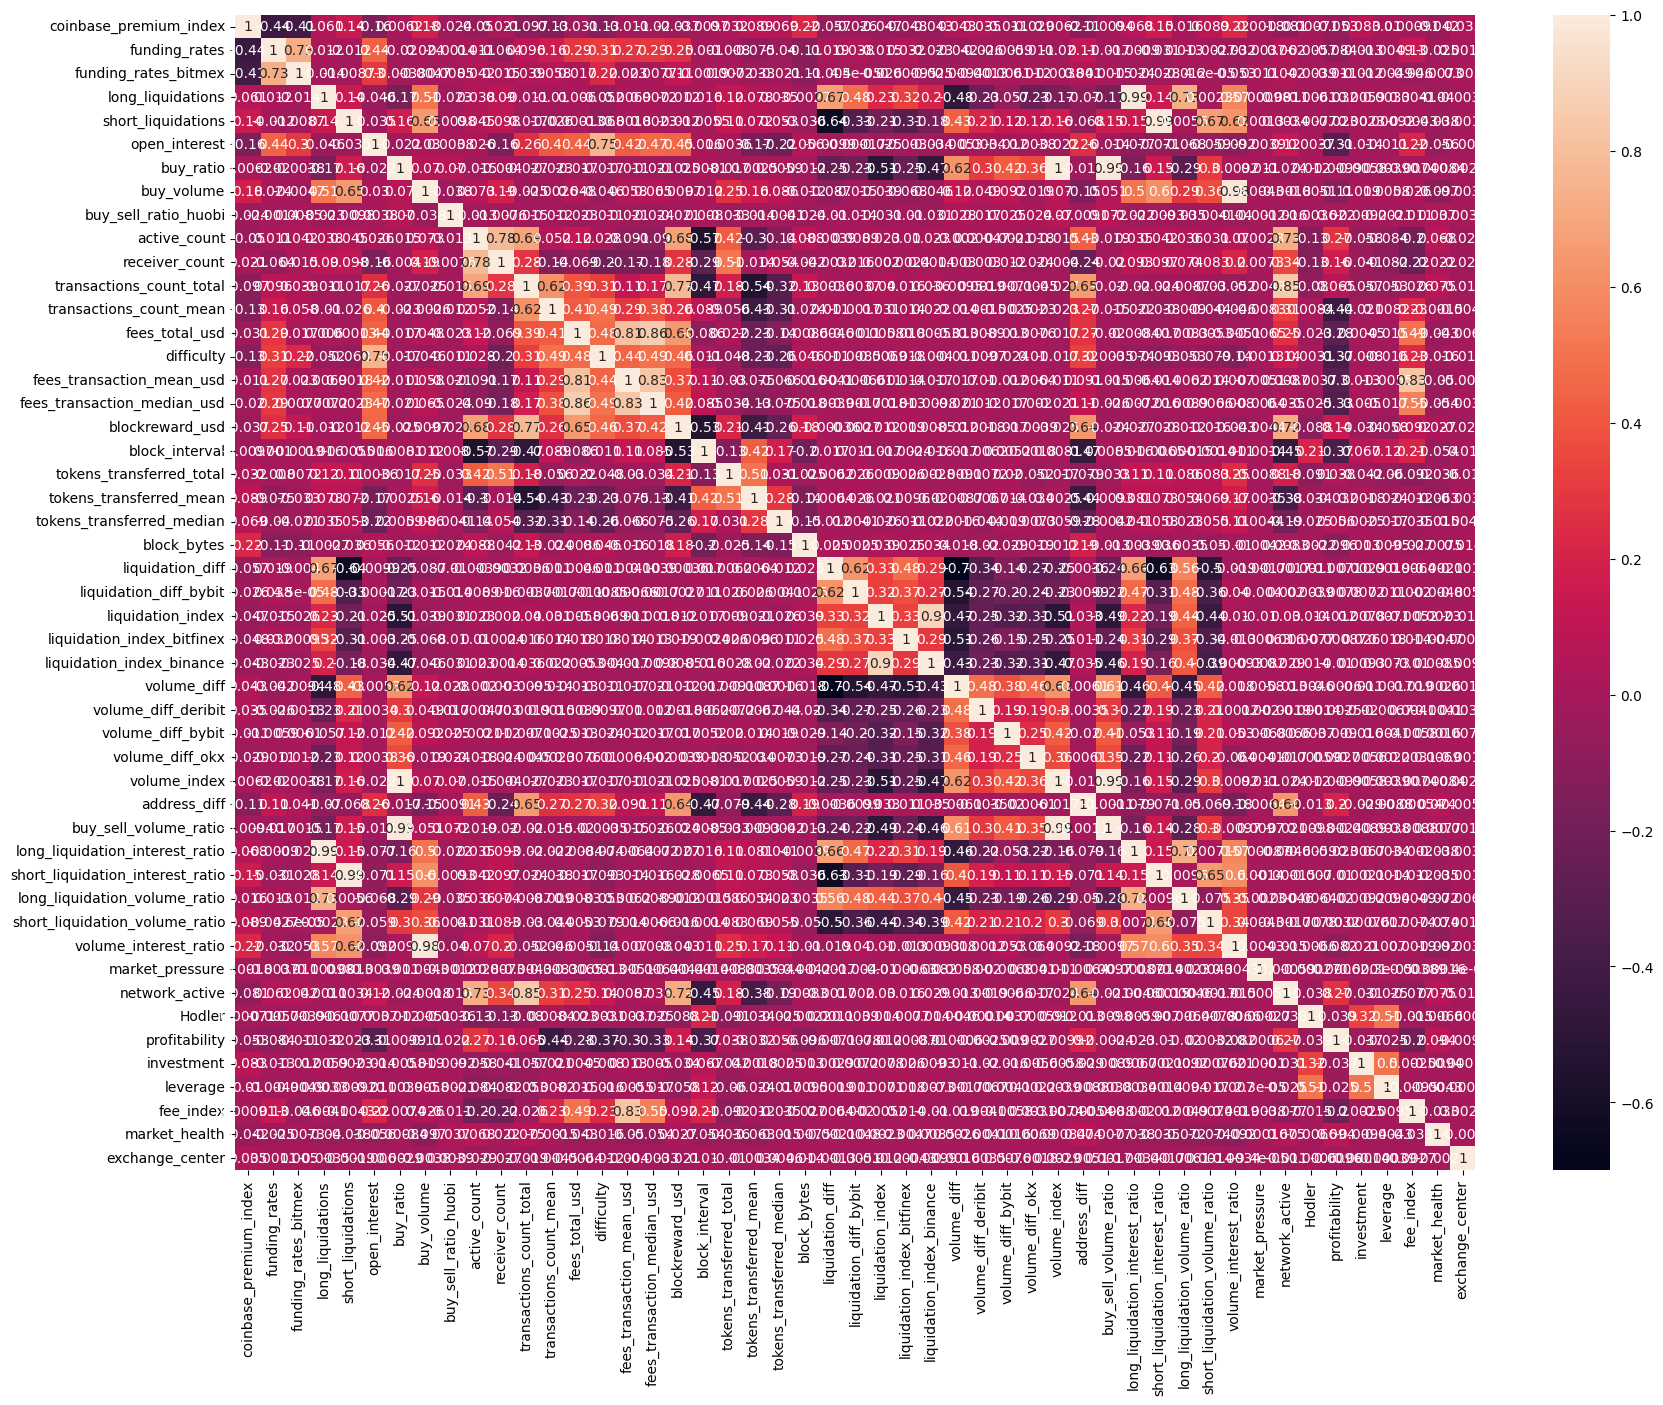

In [15]:
x = df3[df3.ID < '2024-01-01'].drop(columns = ['target', 'ID', '_type']+drop_cols1+drop_cols2)
corr_matrix = x.corr('pearson')

plt.figure(figsize = (20,15))
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [16]:
# 파생 변수 중에 corr 0.0 이상 제거
drop_cols3 = ['long_liquidation_interest_ratio', 'short_liquidation_interest_ratio', 'volume_interest_ratio', 'buy_sell_volume_ratio', 'volume_index']

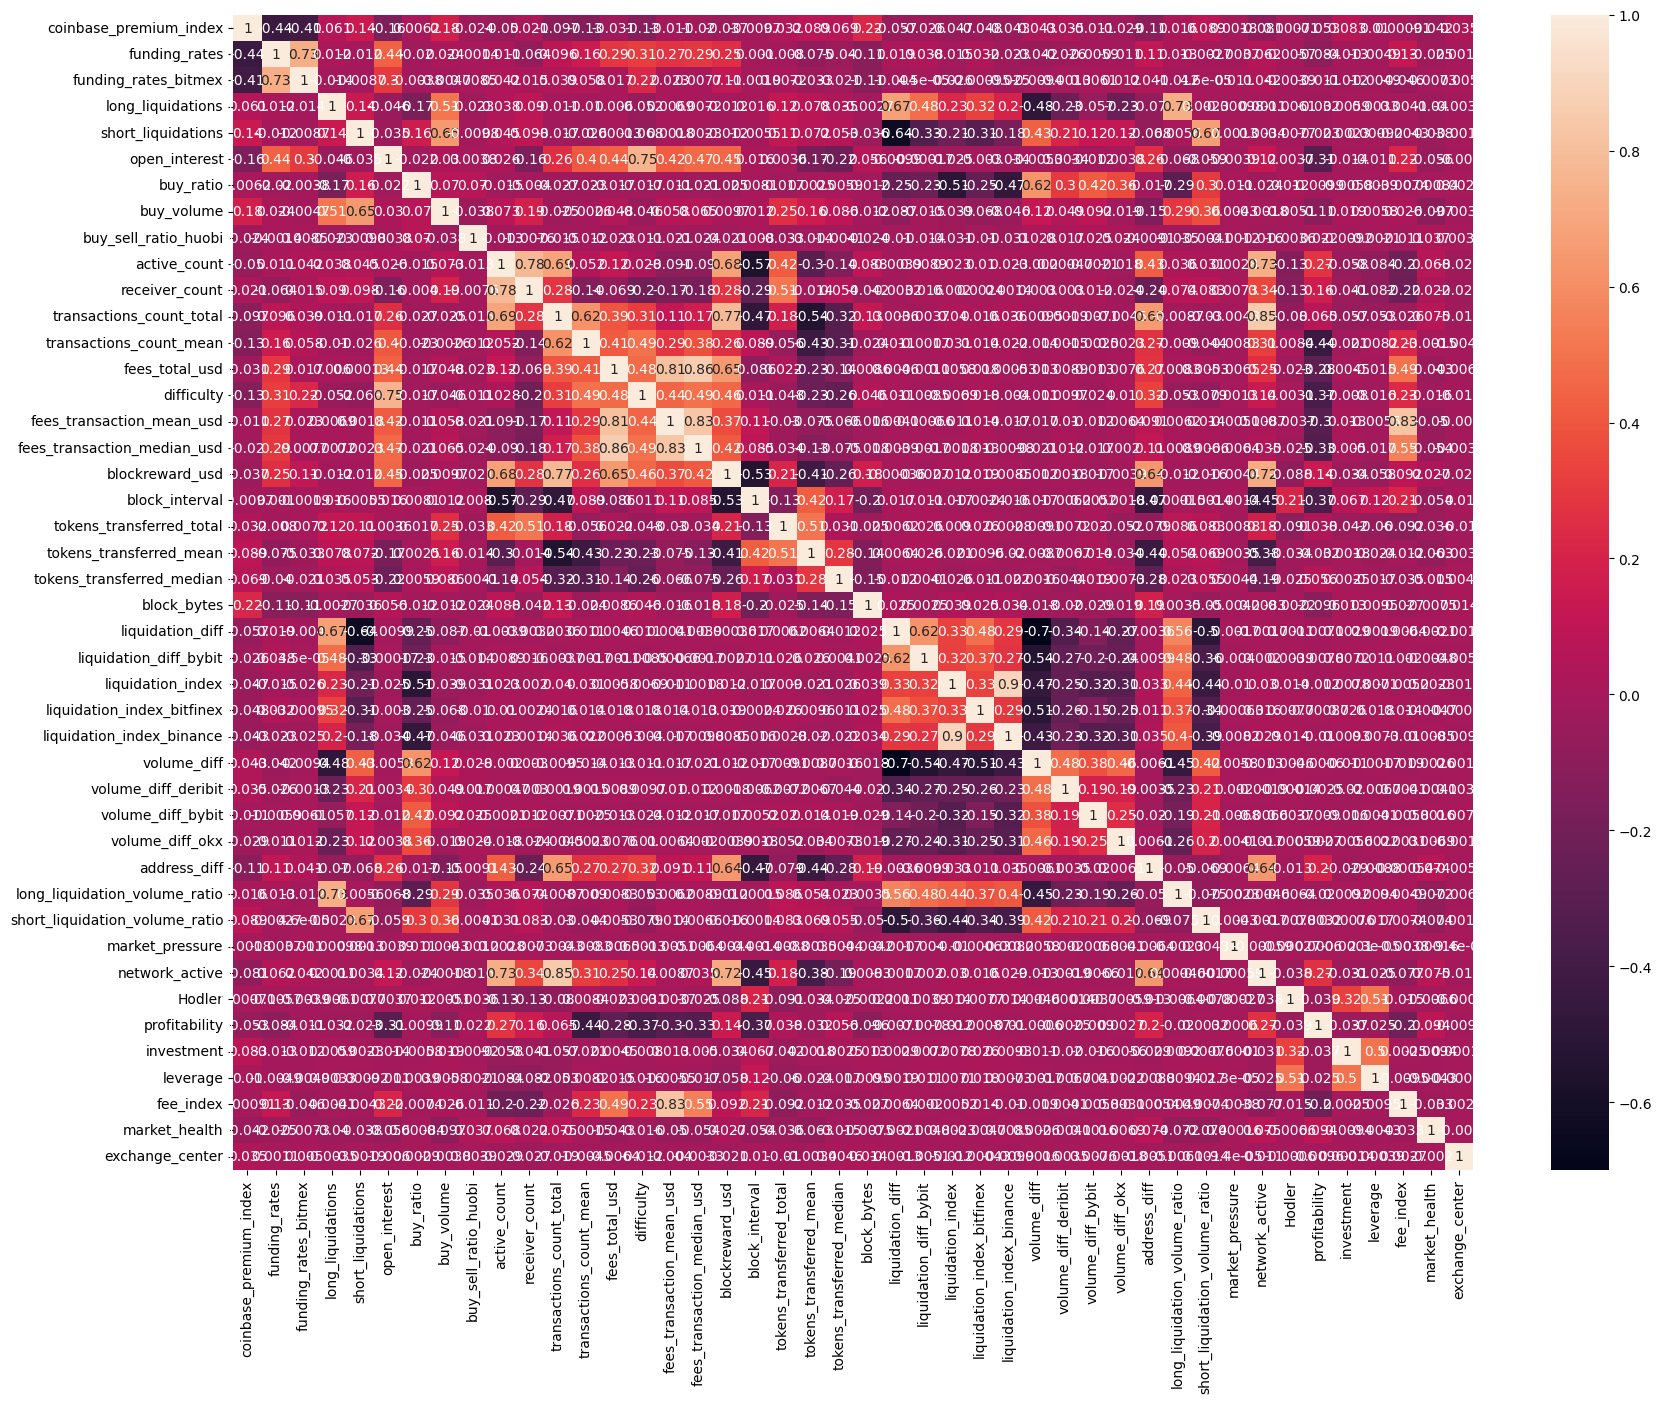

In [17]:
x = df3[df3.ID < '2024-01-01'].drop(columns = ['target', 'ID', '_type']+ drop_cols1 + drop_cols2 + drop_cols3)
corr_matrix = x.corr('pearson')

plt.figure(figsize = (20,15))
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [18]:
# 최종 변수 제거
drop_cols = drop_cols1 + drop_cols2 + drop_cols3
df_select = df3.drop(columns = drop_cols)

In [19]:
# moving average

def moving_average(df, columns, n_days, method = 'mean', adjust = True):
    """    
    df: 입력 DataFrame
    columns: 이동 평균을 계산할 컬럼 리스트
    n_days: 이동 평균을 계산할 기간 (일 수)
    adjust: 시작 지점에서의 편향을 조정할지 여부 (기본값: True)
    """

    output = df.copy()
    for col in columns:
        if method == 'mean':
            new_column_name = f"{col}_MA{n_days}"
            output[new_column_name] = output[col].rolling(window=n_days).mean()
        
        elif method == 'exponential':
            new_column_name = f"{col}_EMA{n_days}"
            output[new_column_name] = output[col].ewm(span=n_days, adjust=adjust).mean()
        
    return output

In [20]:
ma_col_lst = set(conti_cols)-set(drop_cols)

df_select_ma = moving_average(df_select, ma_col_lst, 6)
df_select_ma = moving_average(df_select_ma, ma_col_lst, 12)
df_select_ma = moving_average(df_select_ma, ma_col_lst, 24)
df_select_ma = moving_average(df_select_ma, ma_col_lst, 48)
df_select_ma = moving_average(df_select_ma, ma_col_lst, 72)

In [21]:
col_lst = ['funding_rates', 'open_interest', 'transactions_count_total', 'transactions_count_mean', 'block_mean', 'block_mean_usd',
           'fees_total', 'fees_total_usd', 'fees_reward_percent', 'difficulty', 'utxo_count', 'supply_total', 'hashrate', 'fees_transaction_mean',
           'fees_transaction_mean_usd', 'fees_transaction_median', 'fees_transaction_median_usd', 'blockreward_usd', 'velocity_supply_total', 'address_diff', 'profitability', 'fee_index'  
]

In [22]:
from typing import List

def shift_feature(
    df: pd.DataFrame,
    conti_cols: List[str],
    intervals: List[int],
) -> List[pd.Series]:
    """
    연속형 변수의 shift feature 생성
    Args:
        df (pd.DataFrame)
        conti_cols (List[str]): continuous colnames
        intervals (List[int]): shifted intervals
    Return:
        List[pd.Series]
    """
    df_shift_dict = [
        df[conti_col].shift(interval).rename(f"{conti_col}_{interval}")
        for conti_col in conti_cols
        for interval in intervals
    ]
    return df_shift_dict

# ccf 에서 상관성이 높았던 변수들 
col_lst = ['funding_rates',  'funding_rates_bitmex', 'open_interest', 'transactions_count_total', 'transactions_count_mean', 'block_mean', 'block_mean_usd',
           'fees_total', 'fees_total_usd', 'fees_reward_percent', 'difficulty', 'utxo_count', 'supply_total', 'hashrate', 'fees_transaction_mean',
           'fees_transaction_mean_usd', 'fees_transaction_median', 'fees_transaction_median_usd', 'blockreward_usd', 'tokens_transferred_mean',
           'tokens_transferred_median', 'velocity_supply_total', 'address_diff', 'profitability', 'fee_index'
]
col_lst = set(col_lst) - set(drop_cols)

# 최대 24시간의 shift 피쳐를 계산
shift_list = shift_feature(
    df=df_select_ma, conti_cols=col_lst, intervals=[_ for _ in range(1, 24)]
)
df_select_ma_shift = pd.concat([df_select_ma, pd.concat(shift_list, axis=1)], axis=1)

In [23]:
df_select_ma_shift.head()

coinbase_premium_index  funding_rates  funding_rates_bitmex  \
0               -0.059650       0.005049              0.001400   
1               -0.053047       0.005049              0.001400   
2               -0.057952       0.005049              0.001400   
3               -0.058912       0.005067              0.001518   
4               -0.061373       0.006210              0.008400   

   long_liquidations  short_liquidations  open_interest  buy_ratio  \
0              0.012               0.000   6.271344e+09   0.475003   
1              0.000               0.712   6.288683e+09   0.623454   
2              0.000               0.000   6.286796e+09   0.506785   
3              0.593               0.000   6.284575e+09   0.466518   
4              0.361               0.000   6.291582e+09   0.491559   

     buy_volume  buy_sell_ratio_huobi  active_count  ...  fees_total_usd_14  \
0  4.648309e+07              4.046784       67987.0  ...                NaN   
1  3.975599e+07             14.473239       30593.0  ...                NaN   
2  2.405402e+07              3.529514       33897.0  ...                NaN   
3  2.860215e+07              6.477528       32717.0  ...                NaN   
4  3.087720e+07              0.711501       45176.0  ...                NaN   

   fees_total_usd_15  fees_total_usd_16  fees_total_usd_17  fees_total_usd_18  \
0                NaN                NaN                NaN                NaN   
1                NaN                NaN                NaN                NaN   
2                NaN                NaN                NaN                NaN   
3                NaN                NaN                NaN                NaN   
4                NaN                NaN                NaN                NaN   

   fees_total_usd_19  fees_total_usd_20  fees_total_usd_21  fees_total_usd_22  \
0                NaN                NaN                NaN                NaN   
1                NaN                NaN                NaN                NaN   
2                NaN                NaN                NaN                NaN   
3                NaN                NaN                NaN                NaN   
4                NaN                NaN                NaN                NaN   

   fees_total_usd_23  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  

[5 rows x 612 columns]

In [24]:
train_df = df_select_ma_shift[df_select_ma_shift._type == 'train'].drop(columns = '_type')
test_df = df_select_ma_shift[df_select_ma_shift._type == 'test'].drop(columns = '_type')

# train valid split

### random split

In [25]:
# train_test_split 으로 valid set, train set 분리
x_train_random, x_valid_random, y_train_random, y_valid_random = train_test_split(
    train_df.drop(columns = ['ID', 'target']), 
    train_df["target"].astype(int), 
    test_size=0.2,
    random_state=42
)

### time series split

In [26]:
# time series valid, train set 분리
x_train_ts = train_df[train_df.ID < '2023-11-01'].drop(["target", "ID"], axis = 1)
y_train_ts = train_df[train_df.ID < '2023-11-01']["target"].astype(int)

x_valid_ts = train_df[train_df.ID >= '2023-11-01'].drop(["target", "ID"], axis = 1)
y_valid_ts = train_df[train_df.ID >= '2023-11-01']["target"].astype(int)

# Model Training

In [27]:
# 각 열에서 누락된 값의 수를 계산
missing_values = train_df.isna().sum()

# 누락된 값의 백분율 계산
missing_percentage = (missing_values / len(train_df)) * 100

# 누락된 값 비율을 기준으로 열 정렬
sorted_missing_percentage = missing_percentage.sort_values(ascending=False)
sorted_missing_percentage

buy_sell_ratio_huobi_MA72    0.810502
fees_total_usd_MA72          0.810502
open_interest_MA72           0.810502
volume_diff_okx_MA72         0.810502
buy_volume_MA72              0.810502
                               ...   
tokens_transferred_total     0.000000
tokens_transferred_mean      0.000000
Hodler                       0.000000
funding_rates_bitmex         0.000000
coinbase_premium_index       0.000000
Length: 611, dtype: float64

## LGBM

In [85]:
from catboost import CatBoostClassifier, Pool
# CatBoost params
params = {
    'iterations': 1000,
    'learning_rate': 0.02,
    'depth': 6,
    'loss_function': 'MultiClass',
    'eval_metric': 'MultiClass',
    'random_seed': 42,
    'verbose': 0
}

In [88]:
def catboost_train(x_train, y_train, x_valid, y_valid, params):
    # CatBoost dataset
    train_pool = Pool(x_train, y_train)
    valid_pool = Pool(x_valid, y_valid)
    
    # CatBoost train
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=False)
    
    # CatBoost predict
    y_valid_pred = model.predict_proba(x_valid)
    y_valid_pred_class = np.argmax(y_valid_pred, axis=1)
    
    # Score check
    accuracy = accuracy_score(y_valid, y_valid_pred_class)
    auroc = roc_auc_score(y_valid, y_valid_pred, multi_class="ovr")
    return model, y_valid_pred_class, accuracy, auroc

In [89]:
catboost_random, y_pred_random, accuracy_random, auroc_random = catboost_train(x_train_random, y_train_random, x_valid_random, y_valid_random, params)
catboost_ts, y_pred_ts, accuracy_ts, auroc_ts = catboost_train(x_train_ts, y_train_ts, x_valid_ts, y_valid_ts, params)

KeyboardInterrupt: 

In [63]:
print(f"random split - acc: {accuracy_random}, auroc: {auroc_random}")
print(f"ts split - acc: {accuracy_ts}, auroc: {auroc_ts}")

random split - acc: 0.4417808219178082, auroc: 0.6532109411107839
ts split - acc: 0.47404371584699456, auroc: 0.6083226896041238


In [64]:
Counter(y_pred_random)

Counter({2: 914, 1: 827, 3: 8, 0: 3})

In [65]:
Counter(y_pred_ts)

Counter({2: 942, 1: 521, 0: 1})

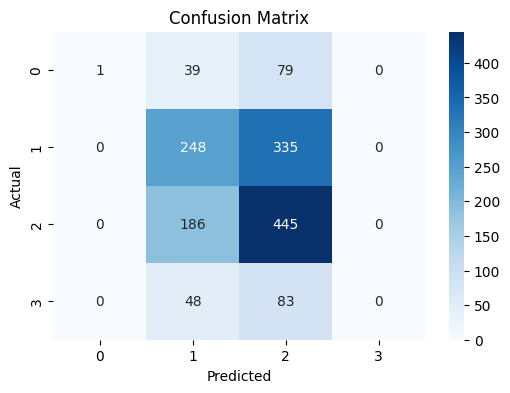

In [66]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_valid_ts,y_pred_ts)

# 시각화
plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title('Confusion Matrix')
plt.show()

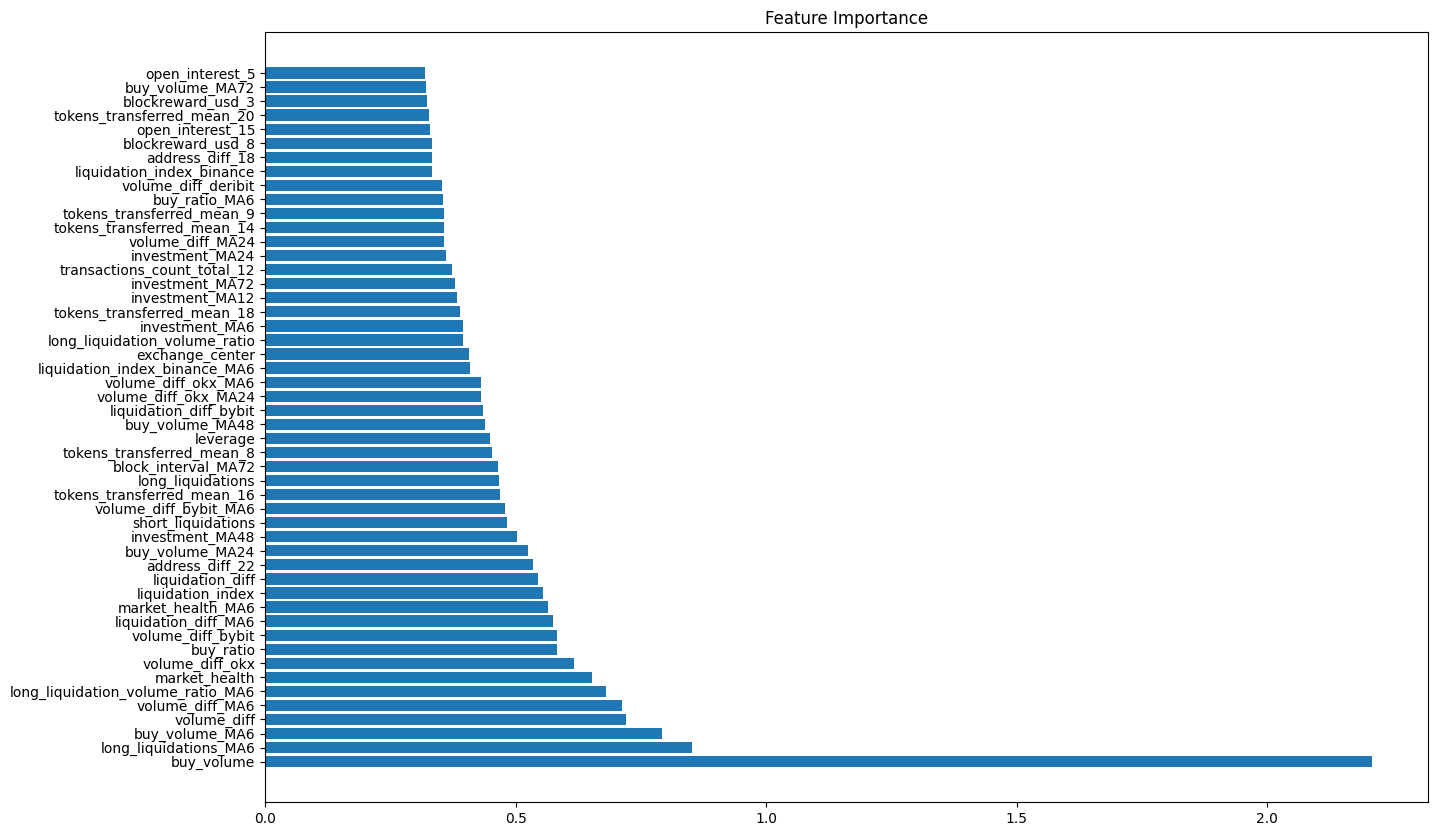

In [67]:
# Feature Importance
feature_importance = catboost_ts.get_feature_importance()
feature_names = x_train_ts.columns
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
importance_df = importance_df.sort_values('importance', ascending=False).head(50)

plt.figure(figsize=(15, 10))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.title('Feature Importance')
plt.show()

In [68]:
# 변수 중요도 0
np.array(x_train_ts.columns)[np.where(feature_importance == 0)]

array(['fees_transaction_mean_usd_MA48', 'fee_index_MA72',
       'fees_transaction_median_usd_22', 'difficulty_7'], dtype=object)

In [69]:
len(np.where(feature_importance == 0)[0])

4

### Inference

In [70]:
# Performance check and retrain on full dataset
x_train_full = train_df.drop(["target", "ID"], axis=1)
y_train_full = train_df["target"].astype(int)

catboost_model = CatBoostClassifier(**params)
catboost_model.fit(x_train_full, y_train_full, verbose=False)

In [71]:
# CatBoost predict on test data
y_test_pred = catboost_model.predict_proba(test_df.drop(["target", "ID"], axis=1))
y_test_pred_class = np.argmax(y_test_pred, axis=1)

In [72]:
Counter(y_test_pred_class)

Counter({2: 1911, 1: 875, 0: 3, 3: 3})

### Output File Save

In [75]:
# output file 할당후 save 
submission_df = submission_df.assign(target = y_test_pred_class)
submission_df.to_csv("output.csv", index=False)

리더보드 제출 결과 : 0.4119